### Imports

In [1]:
import sys
import os, shutil
import torch
import copy
import numpy as np
from matplotlib import pyplot as plt
import open3d
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
import glob
from torch.utils.data import Dataset
from open3d import read_point_cloud
from tqdm import tqdm_notebook
import pandas as pd

In [2]:
%matplotlib inline

### Setting paths and constants

In [3]:
# Working set
# pcd_path = "../DeepMapping/data/2D/10-00-14-P1-6-auto-ccw_5loops_0.6_no_numba/"
# pcd_path = "../DeepMapping/data/2D/10-00-14-P1-6-auto-ccw_5loops_0.6_no_numba_every_tenth_scan/"
# pcd_path = "../DeepMapping/data/2D/ref_run_ccw_r/"
# pcd_path = "../DeepMapping/data/2D/ref_run_ccw_r_tenth_scan/"

In [4]:
# To work set
VOXEL_SZ = 0.2

# FIRST_PCD = 2
# FINAL_PCD = 804
# EVERY_NTH_COUNT = 10
# pcd_path = "/home/sabyasachi/Projects/ati/data/data/datasets/IISC/2019-02-26/ref_run_ccw_r/complete/"


# FIRST_PCD = 2
# FINAL_PCD = 879
# EVERY_NTH_COUNT = 10
# pcd_path = "/home/sabyasachi/Projects/ati/data/data/datasets/IISC/2019-06-12/10-00-14-P1-6-auto-ccw_5loops_0.6_no_numba/complete_extracted/"

In [5]:
# To benchmark set
FIRST_PCD = 2
FINAL_PCD = 800
EVERY_NTH_COUNT = 10
pcd_path = "/home/sabyasachi/Projects/ati/data/data/datasets/Carla/oldDataforCVPR/template0/static/1/_out/"

In [6]:
OUTPUT_DIR = "./temp_save_dataset"

### My I/O fn

In [7]:
def filter_pcd(old_pcd,
               apply_downsample = True,
               downsample_voxel_size = VOXEL_SZ,
               
               apply_outlier_removal = True,
               downsample_radius = 1,
               downsample_neighbors = 20,
               
               apply_crop = True,
               crop_min_arr = np.array([-100,-100,-2]),
               crop_max_arr = np.array([100,100,100]),
               
               apply_cluster = False,
               cluster_neighbours = 30,
               cluster_labels = 2):
    np.random.seed(0)
    pcd = copy.deepcopy(old_pcd)
    
    if apply_outlier_removal:
        denser_pcd, ind = o3d.geometry.radius_outlier_removal(pcd,
                                                              nb_points = downsample_neighbors,
                                                              radius    = downsample_radius)
        pcd = denser_pcd
    
    if apply_downsample:
        voxel_down_pcd = o3d.geometry.voxel_down_sample(pcd, voxel_size = downsample_voxel_size)
        pcd = voxel_down_pcd
    
    if apply_crop:
        cropped_pcd = o3d.geometry.crop_point_cloud(pcd, crop_min_arr, crop_max_arr)
        pcd = cropped_pcd

    if apply_cluster:
        few_pts = np.asarray(pcd.points)
        try:
            few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2).fit_transform(few_pts)
        except Exception as e:
            try:
                few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2, eigen_solver='dense').fit_transform(few_pts)
            except Exception as e:
                few_pts_reduced = few_pts
        clf = MeanShift().fit(few_pts_reduced)
        pcd.points = o3d.utility.Vector3dVector(few_pts[clf.labels_ < cluster_labels])
    
    return pcd

def make_2d(pcd):
    new_pcd = copy.deepcopy(pcd)
    new_pts = np.concatenate([np.asarray(pcd.points)[:,:-1],np.zeros((len(pcd.points),1))], axis=1)
    new_pcd.points = o3d.utility.Vector3dVector(new_pts)
    return new_pcd

def read_pcd(pcd_id):
#     prefix = "".join(["0" for _ in range(3 - len(str(pcd_id)))])
    pcd_file = str(pcd_id) + ".ply"
    pcd = o3d.io.read_point_cloud(os.path.join(pcd_path, pcd_file))
    return pcd

def draw_pcd(pcd, where='mat_2d'):    
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.show()
    elif where is 'mat_2d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], s=1)
        plt.show()
        
def draw_registration_result(src_pcd, dst_pcd, x_pt, y_pt, theta):    
    src_pcd_tmp = copy.deepcopy(src_pcd)
    dst_pcd_tmp = copy.deepcopy(dst_pcd)
    
    src_pcd_tmp.paint_uniform_color([1, 0, 0])  # red source
    dst_pcd_tmp.paint_uniform_color([0, 0, 1])  # blue target
    
    transform_mat = pose2matrix([x_pt, y_pt, 0], [0,0,theta])
    dst_pcd_tmp.transform(transform_mat)
    
    visualizer = o3d.JVisualizer()
    visualizer.add_geometry(src_pcd_tmp)
    visualizer.add_geometry(dst_pcd_tmp)
    visualizer.show()

### DeepMapping ICP fn

In [8]:
def transform_to_global_2D(pose, obs_local):
    """ 
    transform local point cloud to global frame
    row-based matrix product
    pose: <Bx3> each row represents <x,y,theta>
    obs_local: <BxLx2> 
    """
    L = obs_local.shape[1]
    # c0 is the loc of sensor in global coord. frame c0: <Bx2>
    c0, theta0 = pose[:, 0:2], pose[:, 2]
    c0 = c0.unsqueeze(1).expand(-1, L, -1)  # <BxLx2>

    cos = torch.cos(theta0).unsqueeze(-1).unsqueeze(-1)
    sin = torch.sin(theta0).unsqueeze(-1).unsqueeze(-1)
    R_transpose = torch.cat((cos, sin, -sin, cos), dim=1).reshape(-1, 2, 2)

    obs_global = torch.bmm(obs_local, R_transpose) + c0
    return obs_global

def transform_to_global_AVD(pose, obs_local):
    """
    transform obs local coordinate to global corrdinate frame
    :param pose: <Bx3> <x,z,theta> y = 0
    :param obs_local: <BxLx3> (unorganized) or <BxHxWx3> (organized)
    :return obs_global: <BxLx3> (unorganized) or <BxHxWx3> (organized)
    """
    is_organized = 1 if len(obs_local.shape) == 4 else 0
    b = obs_local.shape[0]
    if is_organized:
        H,W = obs_local.shape[1:3]
        obs_local = obs_local.view(b,-1,3) # <BxLx3>
    
    L = obs_local.shape[1]

    c0, theta0 = pose[:,0:2],pose[:,2] # c0 is the loc of sensor in global coord frame c0 <Bx2> <x,z>

    zero = torch.zeros_like(c0[:,:1])
    c0 = torch.cat((c0,zero),-1) # <Bx3> <x,z,y=0>
    c0 = c0[:,[0,2,1]] # <Bx3> <x,y=0,z>
    c0 = c0.unsqueeze(1).expand(-1,L,-1) # <BxLx3>
    
    cos = torch.cos(theta0).unsqueeze(-1).unsqueeze(-1)
    sin = torch.sin(theta0).unsqueeze(-1).unsqueeze(-1)
    zero = torch.zeros_like(sin)
    one = torch.ones_like(sin)
    
    R_y_transpose = torch.cat((cos,zero,-sin,zero,one,zero,sin,zero,cos),dim=1).reshape(-1,3,3)
    obs_global = torch.bmm(obs_local,R_y_transpose) + c0
    if is_organized:
        obs_global = obs_global.view(b,H,W,3)
    return obs_global


def rigid_transform_kD(A, B):
    """
    Find optimal transformation between two sets of corresponding points
    Adapted from: http://nghiaho.com/uploads/code/rigid_transform_3D.py_
    Args:
        A.B: <Nxk> each row represent a k-D points
    Returns:
        R: kxk
        t: kx1
        B = R*A+t
    """
    assert len(A) == len(B)
    N,k = A.shape
    
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))

    H = np.matmul(np.transpose(AA) , BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.matmul(Vt.T , U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[k-1,:] *= -1
        R = np.matmul(Vt.T , U.T)

    t = np.matmul(-R,centroid_A.T) + centroid_B.T
    t = np.expand_dims(t,-1)
    return R, t

def estimate_normal_eig(data):
    """
    Computes the vector normal to the k-dimensional sample points
    """
    data -= np.mean(data,axis=0)
    data = data.T
    A = np.cov(data)
    w,v = np.linalg.eig(A)
    idx = np.argmin(w)
    v = v[:,idx]
    v /= np.linalg.norm(v,2)
    return v
    
def surface_normal(pc,n_neighbors=6):
    """
    Estimate point cloud surface normal
    Args:
        pc: Nxk matrix representing k-dimensional point cloud
    """
    
    n_points,k = pc.shape
    v = np.zeros_like(pc)
    
    # nn search
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(pc)
    _, indices = nbrs.kneighbors(pc)
    neighbor_points = pc[indices]
    for i in range(n_points):
        # estimate surface normal
        v_tmp = estimate_normal_eig(neighbor_points[i,])
        v_tmp[abs(v_tmp)<1e-5] = 0
        if v_tmp[0] < 0:
            v_tmp *= -1
        v[i,:] = v_tmp
    return v


def point2plane_metrics_2D(p,q,v):
    """
    Point-to-plane minimization
    Chen, Y. and G. Medioni. “Object Modelling by Registration of Multiple Range Images.” 
    Image Vision Computing. Butterworth-Heinemann . Vol. 10, Issue 3, April 1992, pp. 145-155.
    
    Args:
        p: Nx2 matrix, moving point locations
        q: Nx2 matrix, fixed point locations
        v:Nx2 matrix, fixed point normal
    Returns:
        R: 2x2 matrix
        t: 2x1 matrix
    """
    assert q.shape[1] == p.shape[1] == v.shape[1] == 2, 'points must be 2D'
    
    p,q,v = np.array(p),np.array(q),np.array(v)
    c = np.expand_dims(np.cross(p,v),-1)
    cn = np.concatenate((c,v),axis=1)  # [ci,nix,niy]
    C = np.matmul(cn.T,cn)
    if np.linalg.cond(C)>=1/sys.float_info.epsilon:
        # handle singular matrix
        raise ArithmeticError('Singular matrix')
    
#     print(C.shape)
    qp = q-p
    b = np.array([
        [(qp*cn[:,0:1]*v).sum()],
        [(qp*cn[:,1:2]*v).sum()],
        [(qp*cn[:,2:]*v).sum()],
    ])

    X = np.linalg.solve(C, b)
    cos_ = np.cos(X[0])[0]
    sin_ = np.sin(X[0])[0]
    R = np.array([
        [cos_,-sin_],
        [sin_,cos_]
    ])
    t = np.array(X[1:])
    return R,t

def icp(src,dst,nv=None,n_iter=100,init_pose=[0,0,0],torlerance=1e-6,metrics='point',verbose=False):
    '''
    Currently only works for 2D case
    Args:
        src: <Nx2> 2-dim moving points
        dst: <Nx2> 2-dim fixed points
        n_iter: a positive integer to specify the maxium nuber of iterations
        init_pose: [tx,ty,theta] initial transformation
        torlerance: the tolerance of registration error
        metrics: 'point' or 'plane'
        
    Return:
        src: transformed src points
        R: rotation matrix
        t: translation vector
        R*src + t
    '''
    n_src = src.shape[0]
    if metrics == 'plane' and nv is None:
        nv = surface_normal(dst)

    #src = np.matrix(src)
    #dst = np.matrix(dst)
    #Initialise with the initial pose estimation
    R_init = np.array([[np.cos(init_pose[2]),-np.sin(init_pose[2])],
                   [np.sin(init_pose[2]), np.cos(init_pose[2])] 
                      ])
    t_init = np.array([[init_pose[0]],
                   [init_pose[1]]
                      ])  
    
    #src =  R_init*src.T + t_init
    src = np.matmul(R_init,src.T) + t_init
    src = src.T
    
    R,t = R_init,t_init

    prev_err = np.inf
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(dst)
    for i in range(n_iter):
        # Find the nearest neighbours
        _, indices = nbrs.kneighbors(src)

        # Compute the transformation
        if metrics == 'point':
            R0,t0 = rigid_transform_kD(src,dst[indices[:,0]])
        elif metrics=='plane':
            try:
                R0,t0 = point2plane_metrics_2D(src,dst[indices[:,0]], nv[indices[:,0]]) 
            except ArithmeticError:
                print('Singular matrix')
                return src,R,t
        else:
            raise ValueError('metrics: {} not recognized.'.format(metrics))
        # Update dst and compute error
        src = np.matmul(R0,src.T) + t0
        src = src.T

        R = np.matmul(R0,R)
        t = np.matmul(R0,t) + t0
        #R = R0*R
        #t = R0*t + t0
        current_err = np.sqrt((np.array(src-dst[indices[:,0]])**2).sum()/n_src)

        if verbose:
            print('iter: {}, error: {}'.format(i,current_err))
            
        if  np.abs(current_err - prev_err) < torlerance:
            break
        else:
            prev_err = current_err
            
    return src,R,t


def compute_ate(output,target):
    """
    compute absolute trajectory error for avd dataset
    Args:
        output: <Nx3> predicted trajectory positions, where N is #scans
        target: <Nx3> ground truth trajectory positions
    Returns:
        trans_error: <N> absolute trajectory error for each pose
        output_aligned: <Nx3> aligned position in ground truth coord
    """
    R,t = rigid_transform_kD(output,target)
    output_aligned = np.matmul(R , output.T) + t
    output_aligned = output_aligned.T

    align_error = np.array(output_aligned - target)
    trans_error = np.sqrt(np.sum(align_error**2,1))
    
    ate = np.sqrt(np.dot(trans_error,trans_error) / len(trans_error))

    return ate,output_aligned

def remove_invalid_pcd(pcd):
    """
    remove invalid in valid points that have all-zero coordinates
    pcd: open3d pcd objective
    """
    pcd_np = np.asarray(pcd.points) # <Nx3>
    non_zero_coord = np.abs(pcd_np) > 1e-6 # <Nx3>
    valid_ind = np.sum(non_zero_coord,axis=-1)>0 #<N>
    valid_ind = list(np.nonzero(valid_ind)[0])
    valid_pcd = open3d.select_down_sample(pcd,valid_ind)
    return valid_pcd

def ang2mat(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c,-s],[s,c]])
    return R

def cat_pose_2D(pose0,pose1):
    """
    pose0, pose1: <Nx3>, numpy array
    each row: <x,y,theta>
    """
    assert(pose0.shape==pose1.shape)
    n_pose = pose0.shape[0]
    pose_out = np.zeros_like(pose0) 
    for i in range(n_pose):
        R0 = ang2mat(pose0[i,-1])
        R1 = ang2mat(pose1[i,-1])
        t0 = np.expand_dims(pose0[i,:2],-1)
        t1 = np.expand_dims(pose1[i,:2],-1)
        
        R = np.matmul(R1,R0)
        theta = np.arctan2(R[1,0],R[0,0])
        t = np.matmul(R1,t0) + t1
        pose_out[i,:2] = t.T
        pose_out[i,2] = theta
    return pose_out

def convert_depth_map_to_pc(depth,fxy,cxy,max_depth=7000,depth_scale=2000):
    """
    create point cloud from depth map and camera instrinsic
    depth: <hxw> numpy array
    fxy: [fx,fy]
    cxy: [cx,cy]
    """
    fx,fy = fxy 
    cx,cy = cxy
    h,w = depth.shape
    
    c,r = np.meshgrid(range(1,w+1), range(1,h+1))
    invalid = depth >= max_depth
    depth[invalid] = 0

    z = depth / float(depth_scale)
    x = z * (c-cx) / fx
    y = z * (r-cy) / fycolor
    xyz = np.dstack((x,y,z)).astype(np.float32)
    return xyz

In [9]:
def transform_to_global_open3d(pose,local_pcd):
    pcd = copy.deepcopy(local_pcd)
    n_pcd = len(pcd)
    for i in range(n_pcd):
        tx,ty,theta = pose[i,:]
        cos,sin = np.cos(theta),np.sin(theta)
        trans = np.array([
                        [cos,-sin,0,tx],
                        [sin,cos,0,ty],
                        [0,0,1,0],
                        [0,0,0,1],
                        ])
        pcd[i].transform(trans) 
    return pcd


def np_to_pcd(xyz):
    """
    convert numpy array to point cloud object in open3d
    """
    xyz = xyz.reshape(-1,3)
    pcd = o3d.PointCloud()
    pcd.points = o3d.Vector3dVector(xyz)
    pcd.paint_uniform_color(np.random.rand(3,))
    return pcd


def load_obs_global_est(file_name):
    """
    load saved obs_global_est.npy file and convert to point cloud object
    """
    obs_global_est = np.load(file_name)
    n_pc = obs_global_est.shape[0]
    pcds = o3d.PointCloud()

    for i in range(n_pc):
        xyz = obs_global_est[i,:,:]
        current_pcd = np_to_pcd(xyz)
        pcds += current_pcd
    return pcds

In [10]:
def plot_global_point_cloud(point_cloud, pose, valid_points, save_dir, **kwargs):
    if torch.is_tensor(point_cloud):
        point_cloud = point_cloud.cpu().detach().numpy()
    if torch.is_tensor(pose):
        pose = pose.cpu().detach().numpy()
    if torch.is_tensor(valid_points):
        valid_points = valid_points.cpu().detach().numpy()

    file_name = 'global_map_pose'
    if kwargs is not None:
        for k, v in kwargs.items():
            file_name = file_name + '_' + str(k) + '_' + str(v)
    save_name = os.path.join(save_dir, file_name)

    bs = point_cloud.shape[0]
    for i in range(bs):
        current_pc = point_cloud[i, :, :]
        idx = valid_points[i, ] > 0
        current_pc = current_pc[idx]

        plt.plot(current_pc[:, 0], current_pc[:, 1], '.')
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.plot(pose[:, 0], pose[:, 1], color='black')
#     plt.savefig(save_name)
    plt.show()
#     plt.close()

def save_global_point_cloud_open3d(point_cloud,pose,save_dir):
    file_name = 'global_map_pose'
    save_name = os.path.join(save_dir, file_name)

    n_pcd = len(point_cloud)
    for i in range(n_pcd):
        current_pc = np.asarray(point_cloud[i].points)
        plt.plot(current_pc[:, 0], current_pc[:, 1], '.',markersize=1)

    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.plot(pose[:, 0], pose[:, 1], color='black')
    plt.savefig(save_name)
    plt.close()

In [11]:
def find_valid_points(local_point_cloud):
    """
    find valid points in local point cloud
        invalid points have all zeros local coordinates
    local_point_cloud: <BxNxk> 
    valid_points: <BxN> indices  of valid point (0/1)
    """
    eps = 1e-6
    non_zero_coord = torch.abs(local_point_cloud) > eps
    valid_points = torch.sum(non_zero_coord, dim=-1)
    valid_points = valid_points > 0
    return valid_points


class SimulatedPointCloud(Dataset):
    def __init__(self, root, trans_by_pose=None):
        # trans_by_pose: <Bx3> pose
        self.root = os.path.expanduser(root)
        self._trans_by_pose = trans_by_pose
        file_list = glob.glob(os.path.join(self.root, '*pcd'))
        self.file_list = sorted(file_list)


#        self.pcds = [] # a list of open3d pcd objects 
        point_clouds = [] #a list of tensor <Lx2>
        for file in self.file_list:
            pcd = read_point_cloud(file)
#            self.pcds.append(pcd)
            current_point_cloud = np.asarray(pcd.points, dtype=np.float32)[:, 0:2]        
            point_clouds.append(current_point_cloud)

        point_clouds = np.asarray(point_clouds)
        try:
            self.point_clouds = torch.from_numpy(point_clouds) # <NxLx2>
        except Exception as e:
            print(e)

            # Handling the uniform size change across all point clouds
            NEW_SIZE = max([current_point_cloud.shape[0] for current_point_cloud in point_clouds]) + 1
            print('Aligning pt clouds to equal size of {}'.format(NEW_SIZE))

            np.random.seed(0)
            new_point_clouds = []
            for current_point_cloud in point_clouds:
                old_size = current_point_cloud.shape[0]
                delta_size = NEW_SIZE - old_size
                idx_list = np.random.randint(low=0, high=old_size, size=delta_size)
                delta_point_cloud = np.array([current_point_cloud[idx] for idx in idx_list])
                new_point_cloud = np.concatenate([current_point_cloud, delta_point_cloud])
                new_point_clouds.append(new_point_cloud)
            point_clouds = np.asarray(new_point_clouds)
            self.point_clouds = torch.from_numpy(point_clouds) # <NxLx2>

        self.valid_points = find_valid_points(self.point_clouds) # <NxL>

        # number of points in each point cloud
        self.n_obs = self.point_clouds.shape[1]

    def __getitem__(self, index):
        pcd = self.point_clouds[index,:,:]  # <Lx2>
        valid_points = self.valid_points[index,:]
        if self._trans_by_pose is not None:
            pcd = pcd.unsqueeze(0)  # <1XLx2>
            pose = self._trans_by_pose[index, :].unsqueeze(0)  # <1x3>
            pcd = utils.transform_to_global_2D(pose, pcd).squeeze(0)
        return pcd,valid_points

    def __len__(self):
        return len(self.point_clouds)

### Let's start

#### Create the dataset (and save it for now)

In [12]:
out_dir = OUTPUT_DIR
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
else:
    shutil.rmtree(out_dir)
    os.makedirs(out_dir)

In [13]:
file_idx = 0
for pcd_idx in tqdm_notebook(np.arange(start=FIRST_PCD, stop=FINAL_PCD+1, step=EVERY_NTH_COUNT)):
    # Read pcd
    some_pcd = read_pcd(pcd_idx)
    
    # Remove zero points
    some_arr = np.asarray(some_pcd.points)
    some_arr = np.array([(x,y,z) for x, y, z in some_arr if not (x == 0 and y == 0 and z == 0)])
    some_pcd.points = o3d.utility.Vector3dVector(some_arr)
    
    # Remove outliers and crop ground circle points
    some_pcd = filter_pcd(some_pcd,
                          apply_downsample = False,
                          apply_outlier_removal = False,
                          apply_crop = True,
                          apply_cluster = False)
    
    # Make it 2d
    some_pcd = make_2d(some_pcd)
    
    # Downsample
    for _ in range(3):
        some_pcd = filter_pcd(some_pcd,
                              apply_downsample = True,
                              apply_outlier_removal = False,
                              apply_crop = False,
                              apply_cluster = False)
    
    # Set filename
    prefix = "".join(["0" for _ in range(3 - len(str(file_idx)))])
    single_pcd_fname = prefix + str(file_idx) + ".pcd"
    single_pcd_path = os.path.join(out_dir, single_pcd_fname)
    
    # Save pcd
    o3d.io.write_point_cloud(single_pcd_path, some_pcd)
    
    file_idx  += 1

In [14]:
single_pcd_path

'./temp_save_dataset/079.pcd'

In [15]:
pcd_path = out_dir

#### SLAM them using ICP

In [16]:
dataset = SimulatedPointCloud(pcd_path)
n_pc = len(dataset)

can't convert np.ndarray of type numpy.object_. The only supported types are: double, float, float16, int64, int32, and uint8.
Aligning pt clouds to equal size of 8916


In [17]:
pose_est = np.zeros((n_pc,3), dtype=np.float32)
print('running icp')

for idx in tqdm_notebook(range(n_pc-1)):
    dst,valid_dst = dataset[idx] 
    src,valid_src = dataset[idx+1]
    
    dst = dst[valid_dst,:].numpy()
    src = src[valid_src,:].numpy()

    _,R0,t0 = icp(src, dst, metrics='plane')
    if idx == 0:
        R_cum = R0
        t_cum = t0
    else:
        R_cum = np.matmul(R_cum , R0)
        t_cum = np.matmul(R_cum,t0) + t_cum
    
    pose_est[idx+1,:2] = t_cum.T
    pose_est[idx+1,2] = np.arctan2(R_cum[1,0],R_cum[0,0]) 

# save_name = os.path.join(checkpoint_dir,'pose_est.npy')
# np.save(save_name,pose_est)

running icp


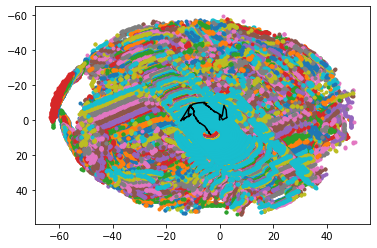

In [18]:
pose_est = torch.from_numpy(pose_est)
local_pc,valid_id = dataset[:]
global_pc = transform_to_global_2D(pose_est,local_pc)
plot_global_point_cloud(global_pc,pose_est,valid_id,"./")

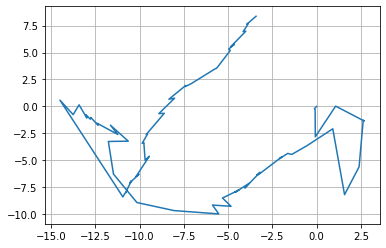

In [19]:
plt.grid()
plt.plot(pose_est[:,0].numpy(), pose_est[:,1].numpy())